In [1]:
import os
import sys
import math
from datetime import date
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from lexicalrichness import LexicalRichness

%load_ext autoreload
%autoreload 2

sys.path.append('..')
from data import constants
from data import dataframe_preparation
from data.utils import tables

# Setup seaborn
sns.set_theme(style="ticks", rc={'text.usetex' : True})
sns.set_context("paper")

# Read main file
df_300_I = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/v2/data/inference/inference_output_stoxx300_first.csv"
df_300_II = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/v2/data/inference/inference_output_stoxx300_second.csv"
df_iterator = (pd.read_csv(f) for f in [df_300_I, df_300_II])
df_300 = pd.concat(df_iterator, ignore_index=True)

id_columns = ['report_id', 'page_no', 'paragraph_no']
df_300["id"] = df_300.apply(lambda row: "_".join([str(row[c]) for c in id_columns]), axis=1)
df_300 = df_300.set_index(["id"])
# TODO: Make sure, this is only a simple overlapping issue (one row) of the two datafiles above!
df_300 = df_300[~df_300.index.duplicated()]
assert df_300.index.is_unique, "Index is not unique. Check the data!"

# Read main file
df_50 = pd.read_csv("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/v2/data/inference/inference_output_stoxx50.csv")
id_columns = ['report_id', 'page_no', 'paragraph_no']
df_50["id"] = df_50.apply(lambda row: "_".join([str(row[c]) for c in id_columns]), axis=1)
df_50 = df_50.set_index(["id"])
assert df_50.index.is_unique, "Index is not unique. Check the data!"

# TODO: Concatentate
df = df_300.append(df_50)

In [2]:
df

,Unnamed: 0,page_no,paragraph_no,text,is_adjunct,report_id,preds_labels,preds_prob
id,,,,,,,,
IWGPlc-AR_2017_68_0,0,68,0,Directors’ Remuneration report continued,True,IWGPlc-AR_2017,"[0, 0, 0, 0, 0]","[0.04931640625, 0.0164642333984375, 0.03314208..."
IWGPlc-AR_2017_68_1,1,68,1,Policy Table for the Chairman and Non-Executiv...,True,IWGPlc-AR_2017,"[0, 0, 0, 0, 0]","[0.049224853515625, 0.0191192626953125, 0.0310..."
IWGPlc-AR_2017_68_2,2,68,2,"Chairman fees Reviewed, but not necessarily in...",True,IWGPlc-AR_2017,"[0, 0, 0, 0, 0]","[0.040618896484375, 0.0173797607421875, 0.0344..."
IWGPlc-AR_2017_68_3,3,68,3,\nA single fee which reflects all Board and Co...,True,IWGPlc-AR_2017,"[0, 0, 0, 0, 0]","[0.038177490234375, 0.01837158203125, 0.032531..."
IWGPlc-AR_2017_68_4,4,68,4,There is no prescribed \nmaximum although fees...,True,IWGPlc-AR_2017,"[0, 0, 0, 0, 0]","[0.03985595703125, 0.017913818359375, 0.029983..."
...,...,...,...,...,...,...,...,...
ch_novartis-AR_2018_245_10,627996,245,10,In a business combination or divestment of a b...,True,ch_novartis-AR_2018,"[0, 0, 0, 0, 0]","[0.046722412109375, 0.023284912109375, 0.04183..."
ch_novartis-AR_2018_245_11,627997,245,11,Changes in the fair value of contingent consid...,True,ch_novartis-AR_2018,"[0, 0, 0, 0, 0]","[0.039337158203125, 0.0160980224609375, 0.0318..."
ch_novartis-AR_2018_245_12,627998,245,12,The effect of unwinding the discount over time...,True,ch_novartis-AR_2018,"[0, 0, 0, 0, 0]","[0.03753662109375, 0.0161590576171875, 0.03079..."


In [2]:
import ast
df["labels"] = df['preds_labels'].apply(ast.literal_eval)

In [3]:
df[constants.cro_sub_category_labels] = pd.DataFrame(df.labels.tolist(), index= df.index)
df[constants.cro_category_labels[0]] = df[constants.cro_sub_category_labels[0:2]].any(axis=1) # df.labels.apply(lambda x: any(x[0:2]))
df[constants.cro_category_labels[1]] = df[constants.cro_sub_category_labels[2:]].any(axis=1) # df.labels.apply(lambda x: any(x[2:]))

In [4]:
# Read master 50 for scaling
df_master_50 = pd.read_csv("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/v2/data/inference/stoxx50_reports.csv")
df_master_50 = df_master_50.set_index("id")
df_master_50['icb_industry'] = df_master_50['icb_industry'].str.slice(3)
df_master_50['country'] = df_master_50['country'].str.upper()
country_mapping = {"GB": "United Kingdom", "CH": "Switzerland", "DE": "Germany", "FR": "France", "IT": "Italy", "DK": "Denmark", "ES": "Spain", "NL": "Netherlands", "BE": "Belgium"}
df_master_50.country.replace(country_mapping, inplace=True)
df_master_50 = df_master_50.rename(columns={"year": "Year"})

In [55]:
df_master_50.groupby("labelling_dataset").count()

,company,orig_report_type,report_type,Year,input_file,output_file,should_infer,is_inferred,company_id,firm_name,ticker,country,icb_industry,icb_supersector
labelling_dataset,,,,,,,,,,,,,,
test,17,17,17,17,17,17,17,17,17,17,0,17,17,17
training,98,98,98,98,98,98,98,98,98,98,0,98,98,98


In [5]:
# Read master new for scaling
df_master_300 = pd.read_csv("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/v2/data/inference/stoxx300_reports.csv")
df_master_300 = df_master_300.set_index("id")
df_meta_300 = pd.read_excel("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/v2/data/inference/stoxx300.xls")
df_master_300 = df_master_300.reset_index().merge(df_meta_300, how="left", left_on="company", right_on="company").set_index("id")

df_master_300['icb_industry'] = df_master_300['industry']
df_master_300 = df_master_300.rename(columns={"year": "Year"})

# TODO: Merge master
df_master = df_master_300.append(df_master_50)

In [6]:
print("Missing matches!")
df_master.query("country != country").company.unique()

Missing matches!


array(['EliaSystemOperatorSA', 'AdidasAG', 'ADOPropertiesSA',
       'BaloiseHoldingAG', 'GVCHoldingsPLC', 'DSVAS', 'AbbLtd',
       'FaureciaSE', 'AdyenNV'], dtype=object)

In [7]:
df["company"] = df.apply(lambda x: x.name.split("-")[0], axis=1)

In [8]:
df = df.reset_index().merge(df_master, how="left", left_on="report_id", right_index=True).set_index("id") 

In [9]:
print("Average of relevant pages per report: ", len(df.groupby(["report_id", "page_no"]).count())/len(df_master))

Average of relevant pages per report:  34.0112451441423


In [39]:
print("Average of paragraphs per report: ", df.groupby(["report_id", "page_no", "paragraph_no"]).size().groupby(["report_id", "page_no"]).size().mean())

Average of paragraphs per report:  16.45091923232175


# Config

In [58]:
category_level = "cro" # ["cro", "cro_sub_type"]
categories = constants.cro_categories if category_level == "cro" else constants.cro_sub_categories
cro_category_labels = [c["label"] for c in categories]

export_dir = os.path.join("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/ICML2021 Financial Disclosures/figures")

colors = [c["color"] for c in categories]

# Descriptive stats

In [11]:
df = df.query("country == country")
df_master = df_master.query("country == country")

In [12]:
len(df_master.company.unique())

337

In [13]:
missing_inferred_reports = set(df_master.index) - set(df.report_id)
print(f"Total number of reports: {len(df_master.index)}, processed reports: {len(df.report_id.unique())}. Missing reports:")
#missing_inferred_reports

Total number of reports: 4801, processed reports: 4498. Missing reports:


In [14]:
print(f'Unique pages: {len(df.groupby(["report_id", "page_no"]).count())}, paragraphs: {len(df)}')

Unique pages: 163506, paragraphs: 2689824


In [15]:
positive_docs = df[df[constants.cro_sub_category_labels].any(axis=1)].copy()
#positive_docs["processed_docs"] = positive_docs.apply(lambda x: dataframe_preparation.spacy_tokenizer(x['text']), axis=1)
print(f"Positive paragraphs: {len(positive_docs)}")

Positive paragraphs: 3892


In [16]:

print(f"Total labels : {positive_docs[constants.cro_sub_category_labels].sum().sum()}")

Total labels : 5501


In [17]:
print("Labels by sub category: ")
positive_docs[constants.cro_sub_category_labels].sum()

Labels by sub category: 


Acute                    741
Chronic                  212
Policy \& Legal         2529
Technology \& Market     624
Reputation              1395
dtype: int64

In [18]:
df_descriptive = pd.DataFrame()
df_tmp = df.groupby("report_id")[constants.cro_sub_category_labels].sum()
df_descriptive["", "Coverage"] = df_tmp.replace(0, np.nan).count()

df_descriptive["Frequency per report", "Mean"] = df_tmp.replace(0, np.nan).mean()
df_descriptive["Frequency per report", "St. Dev."] = df_tmp.replace(0, np.nan).std()
df_descriptive["Frequency per report", "Max"] = df_tmp.max()

"""
df_descriptive["Avg. Lexical diversity per paragraph", "Words"] = df_tmp.apply(lambda x: positive_docs[positive_docs[x.name] > 0].nwords.mean()) 
df_descriptive["Avg. Lexical diversity per paragraph", "Terms"] = df_tmp.apply(lambda x: positive_docs[positive_docs[x.name] > 0].nterms.mean()) 
df_descriptive["Avg. Lexical diversity per paragraph", "TTR"] = df_tmp.apply(lambda x: positive_docs[positive_docs[x.name] > 0].ttr.mean()) 
df_descriptive["Avg. Lexical diversity per paragraph", "MTLD"] = df_tmp.apply(lambda x: positive_docs[positive_docs[x.name] > 0].mtld.mean())
"""

# Add tempory
df_descriptive["Main"] = [constants.map_to_field()[c["parent"]] for c in constants.cro_sub_categories]

df_descriptive.set_index('Main', append=True, inplace=True)
df_descriptive.index.set_names(['second', 'first'], inplace=True)
df_descriptive = df_descriptive.reorder_levels(['first', 'second'])
df_descriptive.index.set_names(['', ''], inplace=True)
df_descriptive = df_descriptive.round(2)
latex_str = tables.export_to_latex(df_descriptive, 
                       filename="pos_paragraphs_descriptive_stats_v2.tex",
                       correct_multicolumn=True,
                       make_bold_row_at=[3],
                       # add_verticalrule_at=[3, 6],
                       index=True, 
                       multirow=False, 
                       multicolumn=False, 
                       bold_rows=True, 
                       multicolumn_format="l", 
                       escape=False,
                       float_format="{:0.2f}".format
                      )
df_descriptive

Frequency per report           \
                                     Coverage                 Mean St. Dev.   
                                                                              
Physical risk   Acute                     492                 1.51     0.96   
                Chronic                   189                 1.12     0.34   
Transition risk Policy \& Legal          1002                 2.52     2.77   
                Technology \& Market      390                 1.60     1.15   
                Reputation                711                 1.96     1.71   

                                          
                                     Max  
                                          
Physical risk   Acute                  8  
                Chronic                3  
Transition risk Policy \& Legal       26  
                Technology \& Market  10  
                Reputation            14

In [33]:
latex_str

'\\begin{tabular}{llrrrr}\n\\toprule &\n                &            &          & Frequency per report &          &     \\\\\n\\bfseries                 & \\bfseries             & \\bfseries  Coverage & \\bfseries                  Mean & \\bfseries  St. Dev. & \\bfseries  Max \\\\\n{} & {} &          &                      &          &     \\\\\n\\midrule\n\\textbf{Physical risk} & \\textbf{Acute} &      492 &                 1.51 &     0.96 &   8 \\\\\n                & \\textbf{Chronic} &      189 &                 1.12 &     0.34 &   3 \\\\\n\\textbf{Transition risk} & \\textbf{Policy \\& Legal} &     1002 &                 2.52 &     2.77 &  26 \\\\\n                & \\textbf{Technology \\& Market} &      390 &                 1.60 &     1.15 &  10 \\\\\n                & \\textbf{Reputation} &      711 &                 1.96 &     1.71 &  14 \\\\\n\\bottomrule\n\\end{tabular}'

# Evolution over the years

Shows the level of *average number of predicted CR's per report* (ACRR) over time.
    

In [106]:
import seaborn as sns

def convert_to_long(df, labels):
    df_long = df.groupby(['Year', 'report_id']).sum()[labels]
    df_long = df_long.reset_index()
    df_long = pd.melt(df_long, id_vars=["Year"], value_vars=labels, var_name='Category', value_name='Average \# mentions (per report)')
    return df_long

def plot_evolution(df, categories, **kwargs):
    colors = [c["color"] for c in categories]
    df = convert_to_long(df, [c["label"] for c in categories])
    ax = sns.lineplot(data=df, x="Year", y="Average \# mentions (per report)", hue="Category", palette=colors, style="Category", **kwargs)
    plt.legend(loc='upper left')
    plt.xlim()
    plt.xlim(min(df.Year),2020)  # max(df.Year))
    ax.set_xlabel("")
    return ax


def plot_evolution_categories(df, categories, **kwargs):
    ax = plot_evolution(df, categories, **kwargs)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    fig = ax.get_figure()
    return fig


def plot_grid(groups, column, categories, exclude_groups=[], ncols=4, **kwargs):
    nrows = math.ceil(len(groups) / ncols)    
    fig = plt.figure(figsize=(12, 15 if nrows > 1 else 5))

    shared_y_ax = None
    shared_x_ax = None
    for idx, c in enumerate(groups):
        if c in exclude_groups:
            is_excluded = True 
            sharey = None
        else:
            is_excluded = False
            sharey = shared_y_ax
        ax = fig.add_subplot(nrows, ncols, idx + 1, sharey=sharey, sharex=shared_x_ax)
        if not shared_y_ax:
            shared_x_ax = ax
        if not is_excluded:
            shared_y_ax = ax
        
        filtered_df = df.query(f"{column} == @c")
        ax2 = plot_evolution(filtered_df, categories, ax=ax, **kwargs)
        ax2.title.set_text(c)
        
        if ax.is_last_row():
            pass
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xlabel(None)

        if ax.is_first_col():
            pass
        else:
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.set_ylabel(None)
        
        if is_excluded:
            plt.setp(ax.get_yticklabels(), visible=True)
            ax.yaxis.tick_right()
            
    return fig         

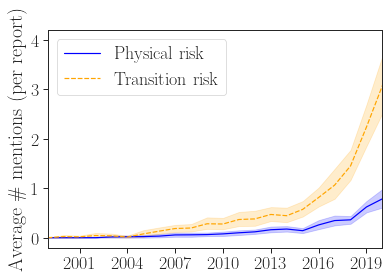

In [119]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 20,
    "font.size": 20,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
}

plt.rcParams.update(tex_fonts)

fig1 = plot_evolution_categories(df, constants.cro_categories)
fig1.savefig(os.path.join(export_dir, "levels_acror_cro_years.pdf"), format='pdf', bbox_inches='tight')

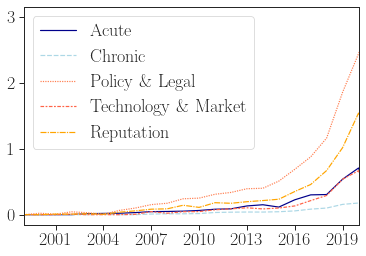

In [108]:
fig2 = plot_evolution_categories(df, constants.cro_sub_categories, ci=None)
fig2.axes[0].set_ylabel("")
fig2.savefig(os.path.join(export_dir, f"levels_acror_cro_sub_type_years.pdf"), format='pdf', bbox_inches='tight')

In [ ]:
all_countries = sorted(df_master.country.unique())
all_countries_fig = plot_grid(all_countries, 'country', constants.cro_categories, exclude_groups=["Norway", "Spain"], ncols=3, ci=None)
all_countries_fig.savefig(os.path.join(export_dir, f"levels_acror_cro_countries.pdf"), format='pdf', bbox_inches='tight')

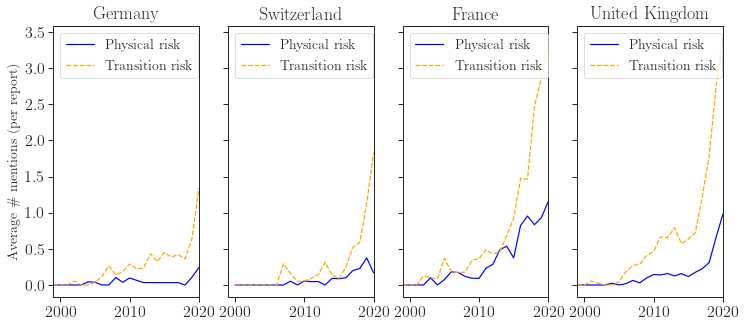

In [120]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
        "axes.titlesize": 18,
}

plt.rcParams.update(tex_fonts)


selected_countries_fig = plot_grid(["Germany", "Switzerland", "France", "United Kingdom"], 'country', constants.cro_categories, ncols=4, ci=None)
selected_countries_fig.savefig(os.path.join(export_dir, f"levels_acror_cro_selected_countries.pdf"), format='pdf', bbox_inches='tight')

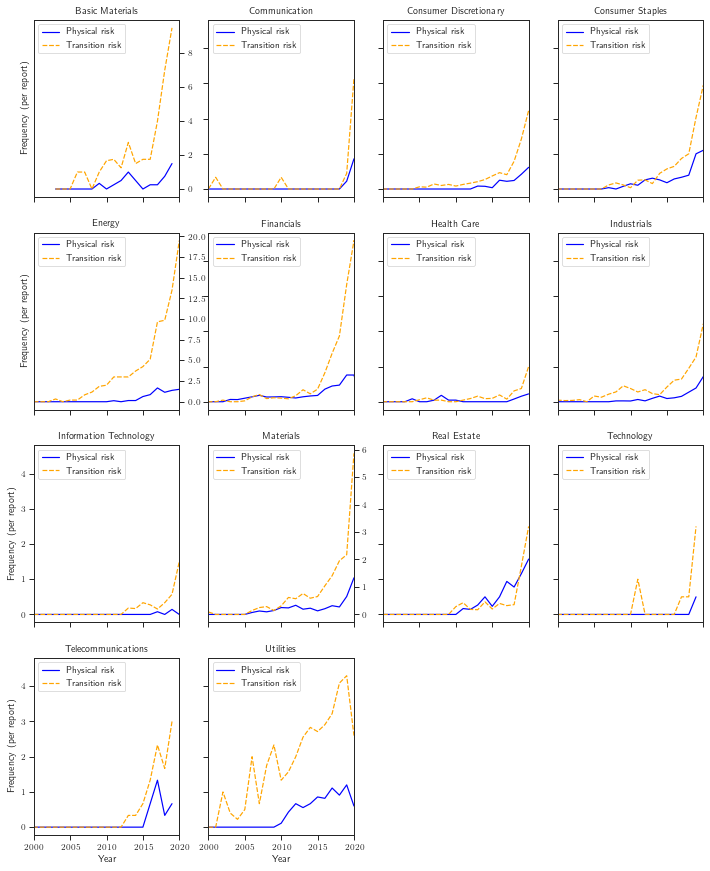

In [45]:
all_industries = sorted(df_master.icb_industry.unique())
all_industries_fig = plot_grid(all_industries, 'icb_industry', constants.cro_categories, exclude_groups=["Energy", "Basic Materials", "Materials"], ncols=4, ci=None)
all_industries_fig.savefig(os.path.join(export_dir, f"levels_acror_cro_industry.pdf"), format='pdf', bbox_inches='tight')

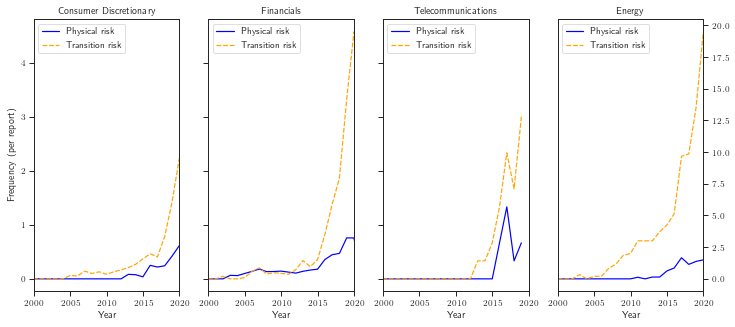

In [46]:
selected_industries_fig = plot_grid(["Consumer Discretionary", "Financials", "Telecommunications", "Energy"], 'icb_industry', constants.cro_categories, exclude_groups=["Energy"], ncols=4, ci=None)
selected_industries_fig.savefig(os.path.join(export_dir, f"levels_acror_cro_selected_industries.pdf"), format='pdf', bbox_inches='tight')

# Frequency distributions

Number of reports (from 2015): 1616


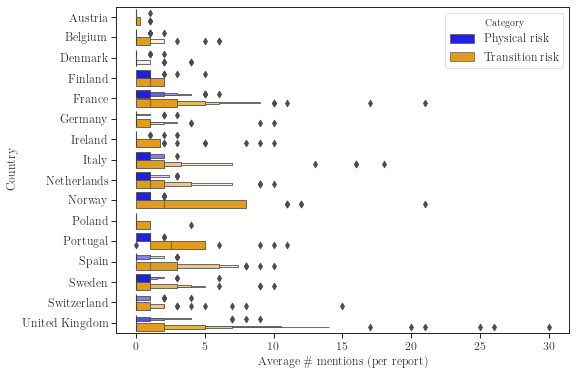

In [113]:


from_year = 2015
labels = [c['label'] for c in constants.cro_categories]
colors = [c["color"] for c in constants.cro_categories]

df_long = df.query("Year >= @from_year").groupby(['country', 'report_id']).sum()[labels]
df_long = df_long.reset_index()
print(f"Number of reports (from {from_year}): {len(df_long.report_id.unique())}")
df_long = pd.melt(df_long, id_vars=["country"], value_vars=labels, var_name='Category', value_name='Average \# mentions (per report)')
df_long = df_long.rename(columns={"country": "Country"})

plt.figure(figsize=(9,6))
ax = sns.boxenplot(y="Country", x="Average \# mentions (per report)", hue="Category", data=df_long, palette=colors)
fig = ax.get_figure()
# plt.tight_layout()
fig.subplots_adjust(left=0.2)
fig.savefig(os.path.join(export_dir, f"cro_country_distribution.pdf"), format='pdf')

Number of reports (from 2015): 1616


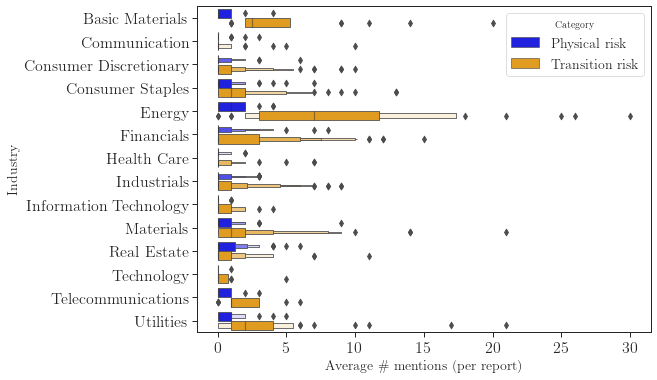

In [121]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.titlesize": 18,
}

plt.rcParams.update(tex_fonts)

df_long = df.query("Year >= @from_year").groupby(['icb_industry', 'report_id']).sum()[labels]
df_long = df_long.reset_index()
print(f"Number of reports (from {from_year}): {len(df_long.report_id.unique())}")
df_long = pd.melt(df_long, id_vars=["icb_industry"], value_vars=labels, var_name='Category', value_name='Average \# mentions (per report)')
df_long = df_long.rename(columns={"icb_industry": "Industry"})

plt.figure(figsize=(9,6))
ax = sns.boxenplot(y="Industry", x="Average \# mentions (per report)", hue="Category", data=df_long, palette=colors)
fig = ax.get_figure()
#plt.tight_layout()
fig.subplots_adjust(left=0.2)
fig.savefig(os.path.join(export_dir, f"cro_industry_distribution.pdf"), format='pdf')

# Preparation

In [ ]:
pr_doc = positive_docs[positive_docs[constants.cro_category_labels[0]]]
tr_doc = positive_docs[positive_docs[constants.cro_category_labels[1]]]
acute_doc = positive_docs[positive_docs[constants.cro_sub_category_labels[0]] > 0]
chron_doc = positive_docs[positive_docs[constants.cro_sub_category_labels[1]] > 0]
policy_doc = positive_docs[positive_docs[constants.cro_sub_category_labels[2]] > 0]
market_doc = positive_docs[positive_docs[constants.cro_sub_category_labels[3]] > 0]
reputation_doc = positive_docs[positive_docs[constants.cro_sub_category_labels[4]] > 0]

# Most frequent ngrams

In [ ]:
from nltk import ngrams, FreqDist

def get_word_counts(docs, most_common=50):
    counts = dict()
    for size in 1, 2:
        counts[size] = FreqDist(ngrams(docs, size))
        
    counts_df = pd.DataFrame(data=counts[1].most_common(most_common), columns=["Unigram", "Frequency"]) # columns=pd.MultiIndex.from_tuples([('Unigram', ''), ('Unigram', 'Frequency')]))
    # counts_df = counts_df.sort_values(by=['Frequency'], ascending=False)
    counts_df = counts_df.join(
        pd.DataFrame(data=counts[2].most_common(most_common), columns=['Bigram', "Frequency2"]) # columns=pd.MultiIndex.from_tuples([('Bigram', ''), ('Bigram', 'Frequency')]))
    )
    counts_df = counts_df.head(most_common)
    
    counts_df['Unigram'] = counts_df['Unigram'].apply(lambda x: " ".join(x))
    counts_df['Bigram'] = counts_df['Bigram'].apply(lambda x: " ".join(x))
    counts_df = counts_df.rename(columns={"Frequency2": "Frequency"})
    return counts_df
    

most_frequent_df = get_word_counts(positive_docs['processed_docs'].explode(), most_common=20)
tables.export_to_latex(most_frequent_df, filename="most_frequent_terms.tex", make_bold_row_at=2, index=False)

# Topic modelling

In [ ]:
import gensim


In [ ]:
dictionary = gensim.corpora.Dictionary(positive_docs["processed_docs"])

In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.9, keep_n= 100000)

# Word Cloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
import matplotlib.pyplot as plt

def gen_wordcloud(docs, export_path, **params):
    input_text = " ".join(docs)
    wordcloud = WordCloud(background_color="white", relative_scaling=0.6, **params).generate(input_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    if export_path:
        wordcloud.to_file(export_path + ".pdf")
        svg = wordcloud.to_svg()
        # with open(export_path + ".svg", "wt") as f:
        #     f.write(svg)

wordclouds_path = os.path.join(export_dir, "wordclouds")
gen_wordcloud(pr_doc["text"], os.path.join(wordclouds_path, "pr"), scale=1, height=400, width=800)
gen_wordcloud(tr_doc["text"], os.path.join(wordclouds_path, "tr"), scale=1, height=400, width=800)

for c in constants.cro_sub_categories:
    docs = positive_docs[positive_docs[c["label"]] > 0]
    path = os.path.join(wordclouds_path, c["code"].lower())
    wordcloud = gen_wordcloud(docs["text"], path, scale=1, height=400, width=600)
    
    